[View in Colaboratory](https://colab.research.google.com/github/sabumjung/Tensorflow/blob/master/03_02_TF_RL_Q-Net+Learning.ipynb)

In [0]:
#강화학습에 필요한 라이브러리를 불러온다.
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
env = gym.make('FrozenLake-v0')

In [0]:
# 텐서플로 내의 그래프를 초기화해준다.
# 초기화를 하지 않으면 동일 이름이 있는 경우에 에러가 나게 됨.
tf.reset_default_graph()

In [0]:
# 텐서플로의 구조를 모델링한다.

# 액션을 선택하기 위해 사용되는 신경망의 feed forward 부분을 구현하는 내용
# 입력값은 1x16 의 벡터로 들어온다
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)

# 가중치는 16x4로 초기화되어 input * w의 결과가 4개 나온다
W = tf.Variable(tf.random_uniform([16,4],0,0.01))

# 행렬곱을 통해 1x16 * 16x4 로 1x4의 결과를 내어줌
Qout = tf.matmul(inputs1,W)

# 가장 예측값이 큰 인덱스를 찾기 위해서?
# argmax는 가장 큰 값일 때의 인덱스를 찾는데 사용하는 함수이다.
predict = tf.argmax(Qout,1)

# 예측된 Q값과 타겟 사이의 차이의 제곱합을 손실로 얻는 과정
# nextQ는 나중에 env.step으로 위에서 선택된 action을 실행하고 난 이후의 상태(다음 상태 s')를 넣었을 때 Q 값들이다.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)

# 손실은 다음 Q와 현재 예측 Q의 차이의 제곱합
loss = tf.reduce_sum(tf.square(nextQ - Qout))

# SGD로 학습한다. 학습률은 0.1
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# SGD로 손실을 최소로 만드는 W를 찾아간다.
updateModel = trainer.minimize(loss)

In [13]:
# 텐서플로는 모든 것이 연산자로 구현이 되어 있어서, valiable 초기화를 해주기 전까지는 아무 값이 할당되어 있지 않다.
init = tf.global_variables_initializer()

# 학습 파라미터 설정
y = .99 # 할인율
e = 0.1 # e-greedy 로 e의 확률로 랜덤한 행동(action)을 하게 함
num_episodes = 2000 # 에피소드 수

# 에피소드당 걸음과 총 보상을 저장하기 위한 리스트
jList = []
rList = []

# 텐서플로를 켜는 Session
with tf.Session() as sess:
    # 초기화하지 않으면 모든 변수에는 아무 값이 없어서 초기화를 해주는 연산을 실행
    sess.run(init)
    
    # 에피소드마다 반복하기
    for i in range(num_episodes):
        # 첫번째 상태를 초기화해주고 보상, 걸음도 초기화
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        # The Q-Network
        while j < 99:
            j+=1
            # Q-network로 부터 나온 q 값에 의해 행동을 선택함(다만 e의 확률로 랜덤한 행동)
            # a, allQ 에는 현재 상태를 바탕으로 한 Q 값들이 나오고 가장 큰 인덱스가 a에 들어있음
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            
            # 환경으로부터 새로운 상태와 보상을 얻음
            s1,r,d,_ = env.step(a[0])
            
            # 새로운 상태를 우리 신경망에 넣어서 Q' 값을 얻음 (1x4) (여기의 max 값이 Q value 에 더해져 target이 됨)
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            # 선택된 액션에 대한 타겟값과 maxq' 를 얻음
            maxQ1 = np.max(Q1)
            # target이 될 Q table을 업데이트 해줌
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            # 예측된 Q 값과 target Q 값을 이용해 신경망을 학습함
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            # 총 보상을 더해줌
            rAll += r
            # 상태를 변경해줌
            s = s1
            # 끝에 도달하면 끝냄
            if d == True:
                # 랜덤하게 행동할 확률을 점점 낮춰줌
                e = 1./((i/50) + 10)
                break
        # 몇걸음만에 끝났는지 기록
        jList.append(j)
        # 에피소드의 총 보상을 기록
        rList.append(rAll)
# 평균적인 보상이 얼마인지 나타냄
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


Percent of succesful episodes: 0.381%


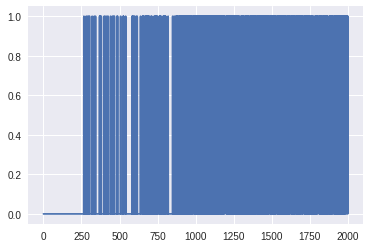

In [14]:
# 그래프 그래기
plt.plot(rList)

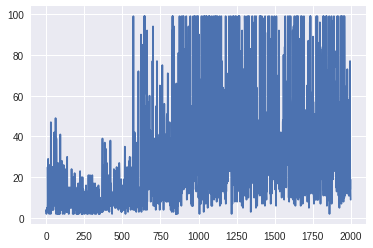

In [15]:
#그래프 그리기
plt.plot(jList)